[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_mog_tutorial.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Mixture of Gaussians (MoG): A tutorial

This notebook gives a short introduction to **MultiMin**: fitting and visualizing **Mixture of Gaussianss (MoG)**.

## Installation and importing

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation


In [2]:
import multimin as mn
mn.show_watermark = True

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import Markdown, display

import numpy as np
np.random.seed(1)
deg = np.pi/180

import warnings
warnings.filterwarnings("ignore")

figprefix = "mog"

Welcome to MultiMin v0.9.7. ¡Al infinito y más allá!


## Theoretical background

The core of `MultiMin` is the **Mixture of Gaussians (MoG)** defined as:

$$
\mathcal{C}_{M,k}(\tilde U; \{w_k\}_M, \{\mu_k\}_M, \{\Sigma_k\}_M) \equiv \sum_{i=1}^{M} w_i\mathcal{N}_k(\tilde U; \tilde \mu_i, \Sigma_i)
$$

where $\tilde U:(u_1,u_2,u_3,\ldots,u_N)$ are random variables and the multivariate normal distribution (MND) $\mathcal{N}_k(\tilde U; \tilde \mu, \Sigma)$ with mean vector $\tilde \mu$ and covariance matrix $\Sigma$ is given by:

$$
\mathcal{N}_k(\tilde U; \tilde \mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^{k} \det \Sigma}} \exp\left[-\frac{1}{2}(\tilde U - \tilde \mu)^{\rm T} \Sigma^{-1} (\tilde U - \tilde \mu)\right]
$$

The covariance matrix $\Sigma_{k\times k}$ elements are defined as $\Sigma_{ij} = \rho_{ij}\sigma_{i}\sigma_{j}$, where $\sigma_i$ is the standard deviation of $u_i$ and $\rho_{ij}$ is the correlation coefficient between variable $u_i$ and $u_j$ ($-1<\rho_{ij}<1$, $\rho_{ii}=1$).

The normalization condition implies that the set of weights $\{w_k\}_M$ are also normalized, i.e., $\sum_i w_i=1$.


## Distribution basics

Below we define and visualize MoGs before using them for fitting.

### Univariate normal distribution

The simplest case is a mixture of univariate normals. Here we create a MoG with two Gaussian components:

In [3]:
MoG = mn.MixtureOfGaussians(
    mus=[0.0, 2.5],
    Sigmas=[1.0, 0.25],
    weights=[0.2, 0.8]
)

We can plot a sample from the distribution:

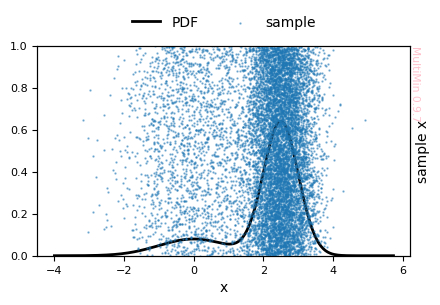

In [4]:
G = MoG.plot_sample(
    properties=["x"],
    sargs=dict(s=0.5, alpha=0.5),
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_univariate_sample_hist.png')

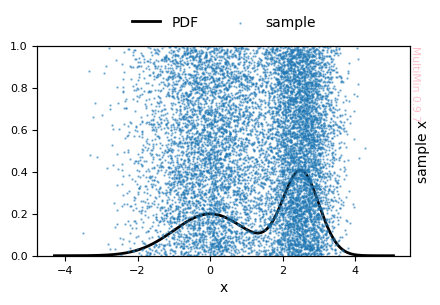

In [5]:
MoG.update_params(
    weights=[0.5, 0.5],
)
G = MoG.plot_sample(
    properties=["x"],
    sargs=dict(s=0.5, alpha=0.5),
    figsize=3
)

Or you may specify in a more complex way the features of the properties:

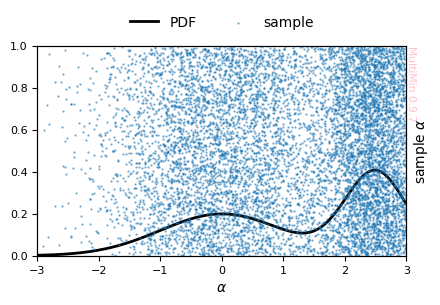

In [6]:
G = MoG.plot_sample(
    properties=dict(x=dict(label=r"$\alpha$", range=[-3,3])),
    sargs=dict(s=0.5, alpha=0.5),
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_univariate_sample_hist.png')

Other methods available for this class:

In [7]:
MoG.describe()


Available methods for this object/class
  get_function()
    Return the source code of ``mog(X)`` and an executable function (type='python'), or LaTeX code with parameters in \begin{array} (type='latex'). Ex. code, mog = MoG.get_function()

  pdf()
    Compute the PDF. Ex. mog.pdf([1.0, 0.5])

  plot_pdf()
    Plot only the PDF of the MoG.

  plot_sample()
    Plot a sample of the MoG. Ex. plot_sample(N=1000, sargs=dict(s=0.5))

  rvs()
    Generate a random sample of points following this Multivariate distribution. When domain is finite, samples are drawn inside the domain (rejection sampling for multivariate; truncated normal for univariate). Ex. mog.rvs(1000)

  sample_mog_likelihood()
    Compute the negative value of the logarithm of the likelihood of a sample. Ex. mog.sample_mog_likelihood(uparams, data=data, pmap=pmap)

  set_domain()
    Set the support domain for each variable (finite or infinite). Ex. set_domain([None, [0, 1], None])

  set_params()
    Set the properties of

You can generate random samples with `rvs`:

In [8]:
sample = MoG.rvs(5000)
sample[:10]

array([[-0.57475964],
       [ 0.51016492],
       [-0.96013615],
       [ 2.70690677],
       [-0.4472173 ],
       [-0.13701182],
       [-0.45402699],
       [ 2.86373214],
       [ 1.27706175],
       [ 0.37566416]])

You can evaluate the PDF at any point:

In [9]:
MoG.pdf(1.3)

0.10807882631874657

### Multivariate distributions

The main strength of **MultiMin** is combining multivariate normal distributions. Below we define a MoG with two three-variate normals:

In [10]:
weights = [0.5,0.5]
mus = [[1.0, 0.5, -0.5], [1.0, -0.5, +0.5],]
sigmas = [[1, 1.2, 2.3], [0.8, 0.2, 3.3]]
angles = [
    [10*deg, 30*deg, 20*deg],
    [-20*deg, 0*deg, 30*deg],
] 
Sigmas = mn.Stats.calc_covariance_from_rotation(sigmas, angles)
MoG = mn.MixtureOfGaussians(mus=mus, weights=weights, Sigmas=Sigmas)

Preview the distribution with a 3D histogram:

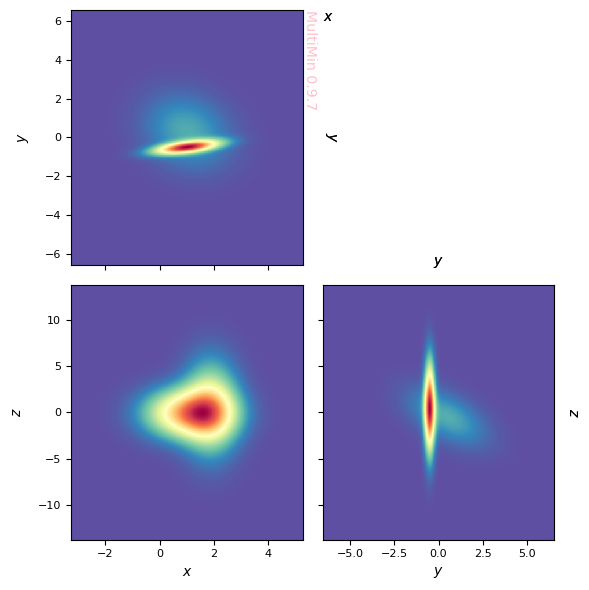

In [11]:
properties=dict(
    x=dict(label=r"$x$",range=None),
    y=dict(label=r"$y$",range=None),
    z=dict(label=r"$z$",range=None),
)

G = MoG.plot_pdf(
    properties=properties,
    figsize=3,
    grid_size=400,
    colorbar=False,
    cmap="Spectral_r",
)
plt.savefig(f'gallery/{figprefix}_3d_sample_density.png')

Another way to visualize the distribution is with **DensityPlot**, which shows pairwise projections. We use a sample of the data:

In [12]:
sample = MoG.rvs(5000)

Plot the sample (2D histograms and scatter on the panels):

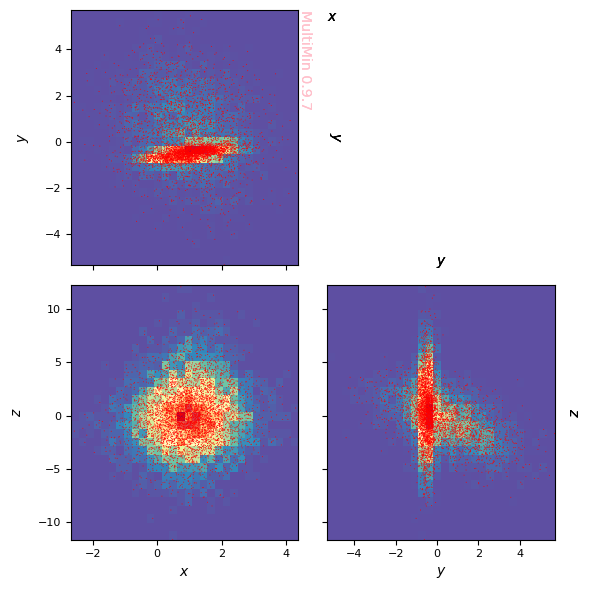

In [13]:
G=mn.DensityPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(sample,**hargs)

sargs=dict(s=0.5,edgecolor='None',color='r')
hist=G.scatter_plot(sample,**sargs)

plt.savefig(f'gallery/{figprefix}_data_density_scatter.png')


**DensityPlot** can also be used for univariate distributions (single-panel histogram and scatter):

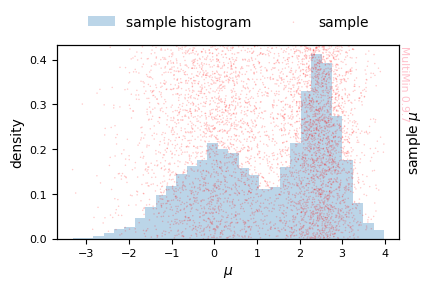

In [14]:
MoG = mn.MixtureOfGaussians(
    mus=[0.0, 2.5],
    Sigmas=[1.0, 0.25],
    weights=[0.5, 0.5]
)

sample = MoG.rvs(5000)

properties=dict(
    x=dict(label=r"$\mu$",range=None),
)

G=mn.DensityPlot(properties,figsize=3)

G.plot_hist(
    sample,
    **dict(bins=30,cmap='Spectral_r', alpha=0.3),
)

sargs=dict(s=1.2,edgecolor='None',color='r')
G.scatter_plot(
    sample,
    **dict(s=1.2,edgecolor='None',color='r',alpha=0.2),
)
plt.savefig(f'gallery/{figprefix}_univariate_density_2gauss.png')

## Fitting data with MoG

We fit by minimizing the **negative normalized log-likelihood**

$$
-\frac{\log \mathcal{L}}{S} = -\frac{1}{S} \sum_{i=1}^{S} \log \mathcal{C}_M(\tilde{U}_i)
$$

over the MoG parameters. Lower values indicate a better fit.

This notebook demonstrates how to use the `multimin.multimin` module for handling multidimensional distributions, specifically designed for asteroid population analysis.

### Univariate normals

The goal of **MultiMin** is to fit a MoG to a given dataset. We start with a univariate example by generating data from a MoG and then fitting it:

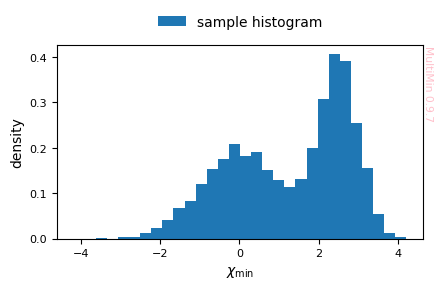

In [15]:
# Create the distribution
MoG = mn.MixtureOfGaussians(
    mus=[0.0, 2.5],
    Sigmas=[1.0, 0.25],
    weights=[0.5, 0.5]
)

# Generate data
sample = MoG.rvs(10000)

# Plot the data
G = mn.DensityPlot(dict(x=dict(label=r"$\chi_\mathrm{min}$",range=None)),figsize=3)
G.plot_hist(sample,**dict(bins=30))
plt.savefig(f'gallery/{figprefix}_univariate_histogram.png')

Fit with a single Gaussian component:

In [16]:
F = mn.FitMoG(data=sample, ngauss=1)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 1
Number of dimensions: 1
Number of samples: 10000
Log-likelihood per point (-log L/N): 2.297019833080217


Run the fitting procedure (use `progress="tqdm"` for better convergence):

In [17]:
F.fit_data(progress="tqdm")

Minimizing: 0it [00:00, ?it/s]

Plot the fit result (histogram of data and fitted PDF):

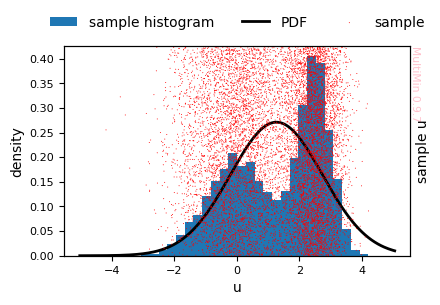

In [18]:
# Univariate: hargs → histogram of sample; fit shown as PDF
F.plot_fit(
    properties=["u"],
    hargs=dict(bins=30),
    sargs=dict(s=0.5,edgecolor='None',color='r'),
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_univariate_fit_1gauss.png')

A single Gaussian cannot capture the bimodal shape. 

Fitting with two Gaussians:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 1
Number of dimensions: 2
Number of samples: 10000
Log-likelihood per point (-log L/N): 2.297019833080217
Log-likelihood per point (-log L/N) after fit:  1.6356125076634171


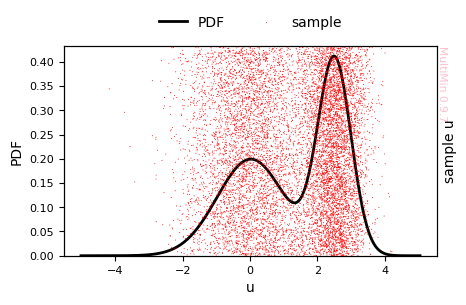

In [19]:
F = mn.FitMoG(data=sample, ngauss=2)
F.fit_data()
print(f"Log-likelihood per point (-log L/N) after fit: ",F.norm_log_l())
# Univariate: no hargs → scatter of sample; fit shown as PDF
F.plot_fit(
    properties=["u"],
    sargs=dict(s=0.5, edgecolor='None', color='r'),
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_univariate_fit_2gauss.png')

Visual inspection shows that the fitted distribution matches the sample well. For a quantitative check we can compare the true and fitted parameters:

In [20]:
MoG.tabulate('distance')

,w,mu_1,sigma_1
component,,,
1,0.5,0.0,1.00
2,0.5,2.5,0.25


In [21]:
F.mog.tabulate('distance')

,w,mu_1,sigma_1
component,,,
2,0.500526,0.025683,1.004006
1,0.499474,2.508023,0.244823


The tables confirm that the fitted parameters are close to the true ones.

You can export the fitted MoG as a callable function for use in other code:

In [22]:
code, mog = F.mog.get_function()

from multimin import Util

def mog(X):

    mu1_1 = 2.508023
    sigma1_1 = 0.494796
    n1 = Util.nmd(X, mu1_1, sigma1_1)

    mu2_1 = 0.025683
    sigma2_1 = 1.002001
    n2 = Util.nmd(X, mu2_1, sigma2_1)

    w1 = 0.499474
    w2 = 0.500526

    return (
        w1*n1
        + w2*n2
    )


Evaluate the fitted PDF at a point:

In [23]:
mog(0.2)

np.float64(0.1962968566936807)

### Multivariate data

We can run a similar workflow for multivariate data:

In [24]:
weights = [0.5,0.5]
mus = [[1.0, 0.5, -0.5], [1.0, -0.5, +0.5],]
sigmas = [[1, 1.2, 2.3], [0.8, 0.2, 3.3]]
angles = [
    [10*deg, 30*deg, 20*deg],
    [-20*deg, 0*deg, 30*deg],
] 
Sigmas = mn.Stats.calc_covariance_from_rotation(sigmas, angles)

MoG = mn.MixtureOfGaussians(mus=mus, weights=weights, Sigmas=Sigmas)

sample = MoG.rvs(5000)

First, fit with a single multivariate normal:

In [25]:
F = mn.FitMoG(data=sample, ngauss=1)
F.fit_data(progress="tqdm")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 5000
Log-likelihood per point (-log L/N): 11.414133112430706


Minimizing: 0it [00:00, ?it/s]

Check the fit (one Gaussian cannot capture two modes):

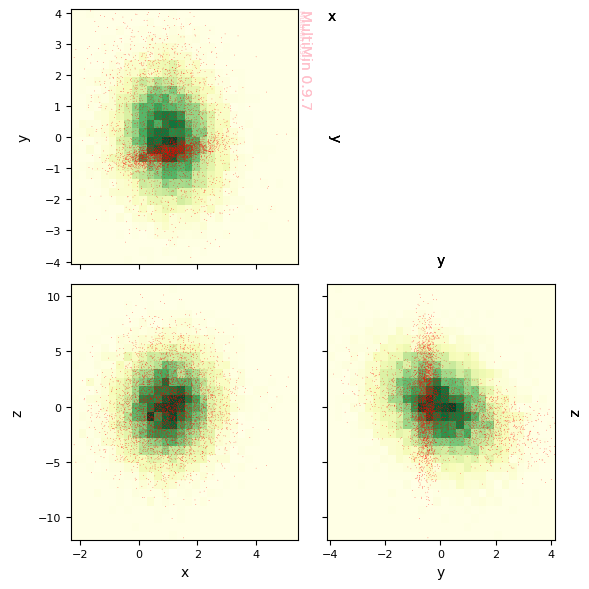

In [26]:
G=F.plot_fit(
    properties=["x","y","z"],
    hargs=dict(bins=30,cmap='YlGn'),
    sargs=dict(s=0.2,edgecolor='None',color='r'),
    figsize=3
)

plt.savefig(f'gallery/{figprefix}_fit_2gauss_3d.png')


Although we can evaluate visually that the fit is not good, we can better check the goodness of fit using a Kolmogorov-Smirnov test. 

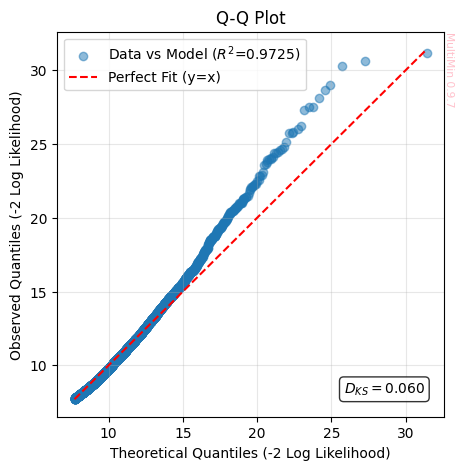

In [27]:
ks, R2 = F.quality_of_fit(plot_qq=True)
plt.savefig(f"gallery/{figprefix}_plot_qq_mog.png")

the **Kolmogorov-Smirnov Statistic ($D_{KS}$)** Measures the maximum absolute distance between the Cumulative Distribution Function (CDF) of the data and that of the model. It represents the "worst point" of local deviation.

$$D_{KS} = \sup_{x} | F_{obs}(x) - F_{model}(x) |$$

The range of the statistics is $D_{KS}\in[0, 1]$, where an acceptable value is $D_{KS}\approx 0$ (Ideally $< 0.05$).

The Q-Q plot is a non-parametric visual diagnostic tool used to assess whether a set of observed data follows a specific theoretical distribution (or a model simulation). For making it we compare the distribution of the **Negative Log-Likelihood** ($-\ln \mathcal{L}$) of the real data against the model's prediction. The plot confronts the **quantiles** of the empirical distribution (data) against the quantiles of the reference distribution (model).

If two distributions $F_{obs}$ and $F_{model}$ are identical, then for any probability $p$, their inverses (the quantiles) must match. Therefore, the points $(x, y) = (Q_{model}, Q_{obs})$ should align on the identity line $y = x$. Since visualizing an $N$-dimensional space is impossible for humans, we use the **Log-Likelihood** as a dimensionality reduction technique. We collapse the vector $\vec{x}$ into a scalar $S = -2 \ln \mathcal{L}(\vec{x})$. If the Q-Q plot of $S$ is correct, we have strong assurance that the model correctly captures the internal correlations and structure of the n-tuples.

* **Ideal Fit (On the $y=x$ line):** The distribution of "rarity" in the observed events perfectly matches the model's prediction. The fit is statistically valid.
* **Tail Deviation (Curved ends):** Points diverging at the extremes (top right or bottom left) indicate "Heavy Tails" (more outliers than predicted) or "Light Tails" (fewer outliers than predicted).
* **Shift or Wrong Slope:** Indicates systematic errors in the mean (displacement) or variance (scale) of the model.

The **Coefficient of Determination on Identity ($R^2$)** measures the variance explained by the model with respect to the ideal line $y=x$. It penalizes both dispersion and bias (displacement) of the prediction.

$$R^2 = 1 - \frac{\sum (y_{obs} - x_{model})^2}{\sum (y_{obs} - \bar{y}_{obs})^2}$$

The range of the statistics is $R^2\in(-\infty, 1]$, where an acceptable value is $R^2\approx 1$ (Ideally $> 0.9$).

In all the metrics, the fit to a single gaussian is poor for the considered data.

Fitting with two Gaussians gives a much better result:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 5000
Log-likelihood per point (-log L/N): 11.414133112430706


Minimizing: 0it [00:00, ?it/s]

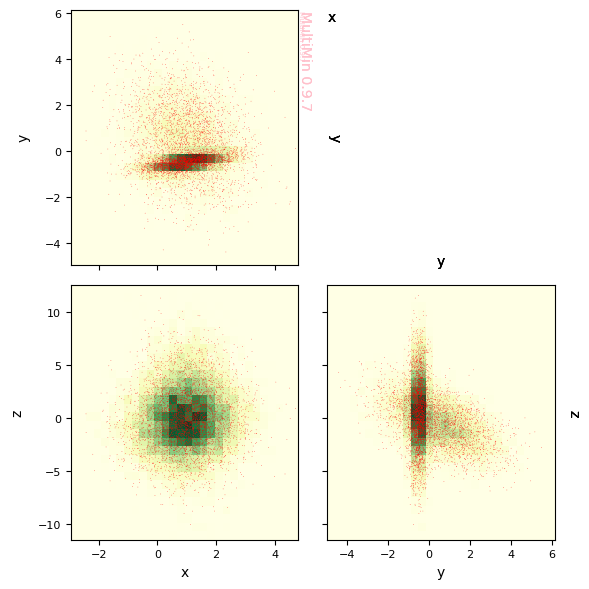

In [28]:
F = mn.FitMoG(data=sample, ngauss=2)
F.fit_data(progress="tqdm")
G=F.plot_fit(
    properties=["x","y","z"],
    hargs=dict(bins=30,cmap='YlGn'),
    sargs=dict(s=0.2,edgecolor='None',color='r'),
    figsize=3
)

plt.savefig(f'gallery/{figprefix}_fit_result_3d.png')


Much better! At least visually. Let's evaluate the quality of fit quantitatively.

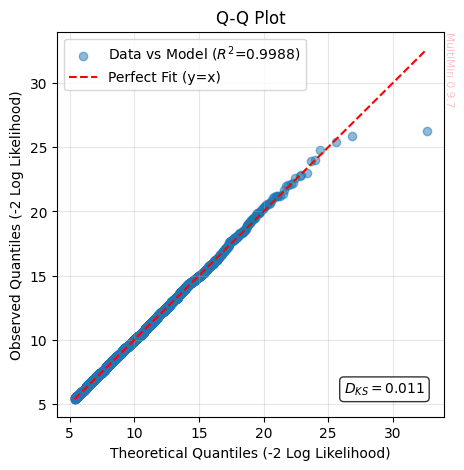

In [29]:
ks, R2 = F.quality_of_fit(plot_qq=True)

Wonderful!

Check the initial and final distributions:

Compare the true and fitted MoG parameters (e.g. means and weights):

In [30]:
MoG.tabulate('distance')

,w,mu_1,mu_2,mu_3,sigma_1,sigma_2,sigma_3,rho_12,rho_13,rho_23
component,,,,,,,,,,
1,0.5,1.0,0.5,-0.5,1.064392,1.510773,2.077169,-0.211137,0.101191,-0.534075
2,0.5,1.0,-0.5,0.5,0.788611,0.241023,3.300000,0.539822,0.000000,0.000000


In [31]:
F.mog.tabulate('distance')

,w,mu_1,mu_2,mu_3,sigma_1,sigma_2,sigma_3,rho_12,rho_13,rho_23
component,,,,,,,,,,
2,0.503237,1.001685,-0.504055,0.534949,0.788532,0.241555,3.349363,0.529687,-0.008064,0.046706
1,0.496763,0.977029,0.528189,-0.558262,1.059248,1.517444,2.067635,-0.205607,0.090194,-0.530379


The agreement is as expected for a good fit.

You can obtain the fitted PDF as explicit code or a callable:

In [32]:
code, mog = F.mog.get_function()

from multimin import Util

def mog(X):

    mu1_1 = 0.977029
    mu1_2 = 0.528189
    mu1_3 = -0.558262
    mu1 = [mu1_1, mu1_2, mu1_3]
    Sigma1 = [[1.122005, -0.330481, 0.197538], [-0.330481, 2.302636, -1.664074], [0.197538, -1.664074, 4.275116]]
    n1 = Util.nmd(X, mu1, Sigma1)

    mu2_1 = 1.001685
    mu2_2 = -0.504055
    mu2_3 = 0.534949
    mu2 = [mu2_1, mu2_2, mu2_3]
    Sigma2 = [[0.621782, 0.100891, -0.021299], [0.100891, 0.058349, 0.037788], [-0.021299, 0.037788, 11.218229]]
    n2 = Util.nmd(X, mu2, Sigma2)

    w1 = 0.496763
    w2 = 0.503237

    return (
        w1*n1
        + w2*n2
    )


Test the callable at a point:

In [33]:
mog([0.2, 0.4, -0.2])

np.float64(0.008417952113047637)

Equivalently, use the MoG's `pdf` method:

In [34]:
F.mog.pdf([0.2, 0.4, -0.2])

0.008417957560775185

## LaTeX outputs

For papers or reports you can export the fitted function in LaTeX:

In [35]:
function, _ = F.mog.get_function(type='latex')
display(Markdown(function))

$$f(\mathbf{x}) = w_1 \, \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_1, \mathbf{\Sigma}_1) + w_2 \, \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_2, \mathbf{\Sigma}_2)$$

where

$$w_1 = 0.496763$$
$$\boldsymbol{\mu}_1 = \left( \begin{array}{c} 0.977029 \\ 0.528189 \\ -0.558262 \end{array}\right)$$
$$\mathbf{\Sigma}_1 = \left( \begin{array}{ccc} 1.122005 & -0.330481 & 0.197538 \\ -0.330481 & 2.302636 & -1.664074 \\ 0.197538 & -1.664074 & 4.275116 \end{array}\right)$$

$$w_2 = 0.503237$$
$$\boldsymbol{\mu}_2 = \left( \begin{array}{c} 1.001685 \\ -0.504055 \\ 0.534949 \end{array}\right)$$
$$\mathbf{\Sigma}_2 = \left( \begin{array}{ccc} 0.621782 & 0.100891 & -0.021299 \\ 0.100891 & 0.058349 & 0.037788 \\ -0.021299 & 0.037788 & 11.218229 \end{array}\right)$$

Here the normal distribution is defined as:

$$\mathcal{N}(\mathbf{x}; \boldsymbol{\mu}, \mathbf{\Sigma}) = \frac{1}{\sqrt{(2\pi)^{{k}} \det \mathbf{\Sigma}}} \exp\left[-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^{\top} \mathbf{\Sigma}^{{-1}} (\

$$f(\mathbf{x}) = w_1 \, \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_1, \mathbf{\Sigma}_1) + w_2 \, \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_2, \mathbf{\Sigma}_2)$$

where

$$w_1 = 0.496763$$
$$\boldsymbol{\mu}_1 = \left( \begin{array}{c} 0.977029 \\ 0.528189 \\ -0.558262 \end{array}\right)$$
$$\mathbf{\Sigma}_1 = \left( \begin{array}{ccc} 1.122005 & -0.330481 & 0.197538 \\ -0.330481 & 2.302636 & -1.664074 \\ 0.197538 & -1.664074 & 4.275116 \end{array}\right)$$

$$w_2 = 0.503237$$
$$\boldsymbol{\mu}_2 = \left( \begin{array}{c} 1.001685 \\ -0.504055 \\ 0.534949 \end{array}\right)$$
$$\mathbf{\Sigma}_2 = \left( \begin{array}{ccc} 0.621782 & 0.100891 & -0.021299 \\ 0.100891 & 0.058349 & 0.037788 \\ -0.021299 & 0.037788 & 11.218229 \end{array}\right)$$

Here the normal distribution is defined as:

$$\mathcal{N}(\mathbf{x}; \boldsymbol{\mu}, \mathbf{\Sigma}) = \frac{1}{\sqrt{(2\pi)^{{k}} \det \mathbf{\Sigma}}} \exp\left[-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^{\top} \mathbf{\Sigma}^{{-1}} (\mathbf{x}-\boldsymbol{\mu})\right]$$

You can also output the parameter table in LaTeX:

In [36]:
latex_table = F.mog.tabulate(type='latex')

\begin{table*}
\begin{tabular}{lrrrrrrrrrr}
\hline
$k$ & $w$ & $\mu_{1}$ & $\mu_{2}$ & $\mu_{3}$ & $\sigma_{1}$ & $\sigma_{2}$ & $\sigma_{3}$ & $\rho_{12}$ & $\rho_{13}$ & $\rho_{23}$ \\
\hline
2 & 0.5032 & 1.002 & -0.5041 & 0.5349 & 0.7885 & 0.2416 & 3.349 & 0.5297 & -0.008064 & 0.04671 \\
1 & 0.4968 & 0.977 & 0.5282 & -0.5583 & 1.059 & 1.517 & 2.068 & -0.2056 & 0.09019 & -0.5304 \\
\hline
\end{tabular}
\end{table*}


---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga